# Load libs

In [26]:
import pandas as pd
import numpy as np

import pygraphviz as pgv
from pgmpy.models.BayesianNetwork import BayesianNetwork
from pgmpy.estimators import MaximumLikelihoodEstimator
from pgmpy.metrics import correlation_score
from pgmpy.metrics import log_likelihood_score
from pgmpy.inference import VariableElimination
from pgmpy.estimators import BayesianEstimator

from datetime import datetime

from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from scipy.stats import chi2_contingency

import os
import pprint

from IPython.display import Image
import matplotlib.pyplot as plt

import ipywidgets as widgets
from IPython.display import display

import networkx as nx
import matplotlib.pyplot as plt
from pgmpy.readwrite import BIFReader


## Load data

In [27]:
df = pd.read_csv('./data/dummy_data.csv')
print(df.head())

         date  temperature month seasons  rain  sunlight  wind  mood  walk
0  2024-01-01           -7   Jan  Winter     0         1    17    11     1
1  2024-01-02           -3   Jan  Winter     0         1    12    17     1
2  2024-01-03          -10   Jan  Winter     0         1    12    24     1
3  2024-01-04           -7   Jan  Winter     0         1    16    16     1
4  2024-01-05           -2   Jan  Winter     1         0    32   -48     0


## Convert the date into date, time format

In [28]:
# Convert 'date' column to datetime format
df['date'] = pd.to_datetime(df['date'])

# Print the dataframe to verify the conversion
df.head()

,date,temperature,month,seasons,rain,sunlight,wind,mood,walk
0,2024-01-01,-7,Jan,Winter,0,1,17,11,1
1,2024-01-02,-3,Jan,Winter,0,1,12,17,1
2,2024-01-03,-10,Jan,Winter,0,1,12,24,1
3,2024-01-04,-7,Jan,Winter,0,1,16,16,1
4,2024-01-05,-2,Jan,Winter,1,0,32,-48,0


# BNN

## Create Bayesian network

In [29]:
# Define the structure of the Bayesian Network
model = BayesianNetwork([
    # ('date', 'temperature'),
    # ('date', 'wind'),
    # ('date', 'rain'),
    # ('date', 'sunlight'),
    ('temperature', 'mood'),
    ('rain', 'mood'),
    ('sunlight', 'mood'),
    ('wind', 'mood'),
    ('temperature', 'rain'),
    ('wind', 'rain'),
    ('temperature', 'sunlight'),
    ('wind', 'sunlight'),
    ('mood', 'walk')
])

# Print the model to verify the structure
print(model.edges())

[('temperature', 'mood'), ('temperature', 'rain'), ('temperature', 'sunlight'), ('mood', 'walk'), ('rain', 'mood'), ('sunlight', 'mood'), ('wind', 'mood'), ('wind', 'rain'), ('wind', 'sunlight')]


## Visualize the network

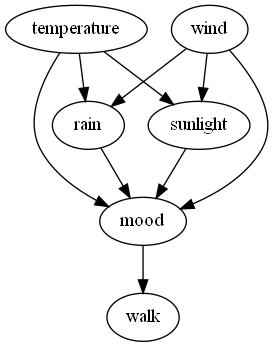

In [30]:
# Save the network as an image
model.to_graphviz().draw('./images/model_1_bn.png', prog='dot')

# Display the network in the notebook
Image(filename='./images/model_1_bn.png')

## Train the model

In [31]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 425 entries, 0 to 424
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         425 non-null    datetime64[ns]
 1   temperature  425 non-null    int64         
 2   month        425 non-null    object        
 3   seasons      425 non-null    object        
 4   rain         425 non-null    int64         
 5   sunlight     425 non-null    int64         
 6   wind         425 non-null    int64         
 7   mood         425 non-null    int64         
 8   walk         425 non-null    int64         
dtypes: datetime64[ns](1), int64(6), object(2)
memory usage: 30.0+ KB
None


In [32]:
# Train the model using MaximumLikelihoodEstimator
model.fit(df.drop(columns=['date', 'month', 'seasons']), estimator=MaximumLikelihoodEstimator, state_names={
    'temperature': list(range(df['temperature'].min(), df['temperature'].max() + 1)),
    'mood': list(range(df['mood'].min(), df['mood'].max() + 1)),
    'wind': list(range(df['wind'].min(), df['wind'].max() + 1)),
    'rain': [0, 1],
    'sunlight': [0, 1]
})

# Predict the 'walk' variable
predicted_walk = model.predict(df.drop(columns=['walk', 'date', 'month', 'seasons']))
print(predicted_walk)

  0%|          | 0/420 [00:00<?, ?it/s]

     walk
0       1
1       1
2       1
3       1
4       0
..    ...
420     0
421     1
422     1
423     1
424     1

[425 rows x 1 columns]


In [33]:
# Check the model for any errors or inconsistencies
model.check_model()

True

## Save the model

In [34]:
# Create the directory if it doesn't exist
if not os.path.exists('./model/'):
    os.makedirs('./model/')

# Get the current date and time
now = datetime.now().strftime('%Y%m%d_%H%M%S')

# Define the model columns
model_columns = df.columns.tolist()

# Define the filename with parameters and date & time
model_filename = f"./model/bayesian_network_{'_'.join([f'{col}_{model_columns[i]}' 
                                                 for i, col in enumerate(model_columns)])}_{now}.bif"

# Save the model in BIF format
model.save(model_filename, filetype='bif')

print(f"Model saved as {model_filename}")


Model saved as ./model/bayesian_network_date_date_temperature_temperature_month_month_seasons_seasons_rain_rain_sunlight_sunlight_wind_wind_mood_mood_walk_walk_20250303_170709.bif


# Look at model stats

## Accuracy & precision

In [35]:
# Calculate accuracy
accuracy = accuracy_score(df['walk'], predicted_walk['walk'])
print(f"Accuracy: {accuracy}")

# Calculate precision
precision = precision_score(df['walk'], predicted_walk['walk'])
print(f"Precision: {precision}")

# Calculate recall
recall = recall_score(df['walk'], predicted_walk['walk'])
print(f"Recall: {recall}")

# Calculate F1-score
f1 = f1_score(df['walk'], predicted_walk['walk'])
print(f"F1-score: {f1}")

Accuracy: 0.9505882352941176
Precision: 0.9825581395348837
Recall: 0.9575070821529745
F1-score: 0.96987087517934


C:\Users\adhav\AppData\Local\Temp\ipykernel_14000\4043196071.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  monthly_metrics = df_to_print.groupby('month').apply(lambda x: pd.Series({


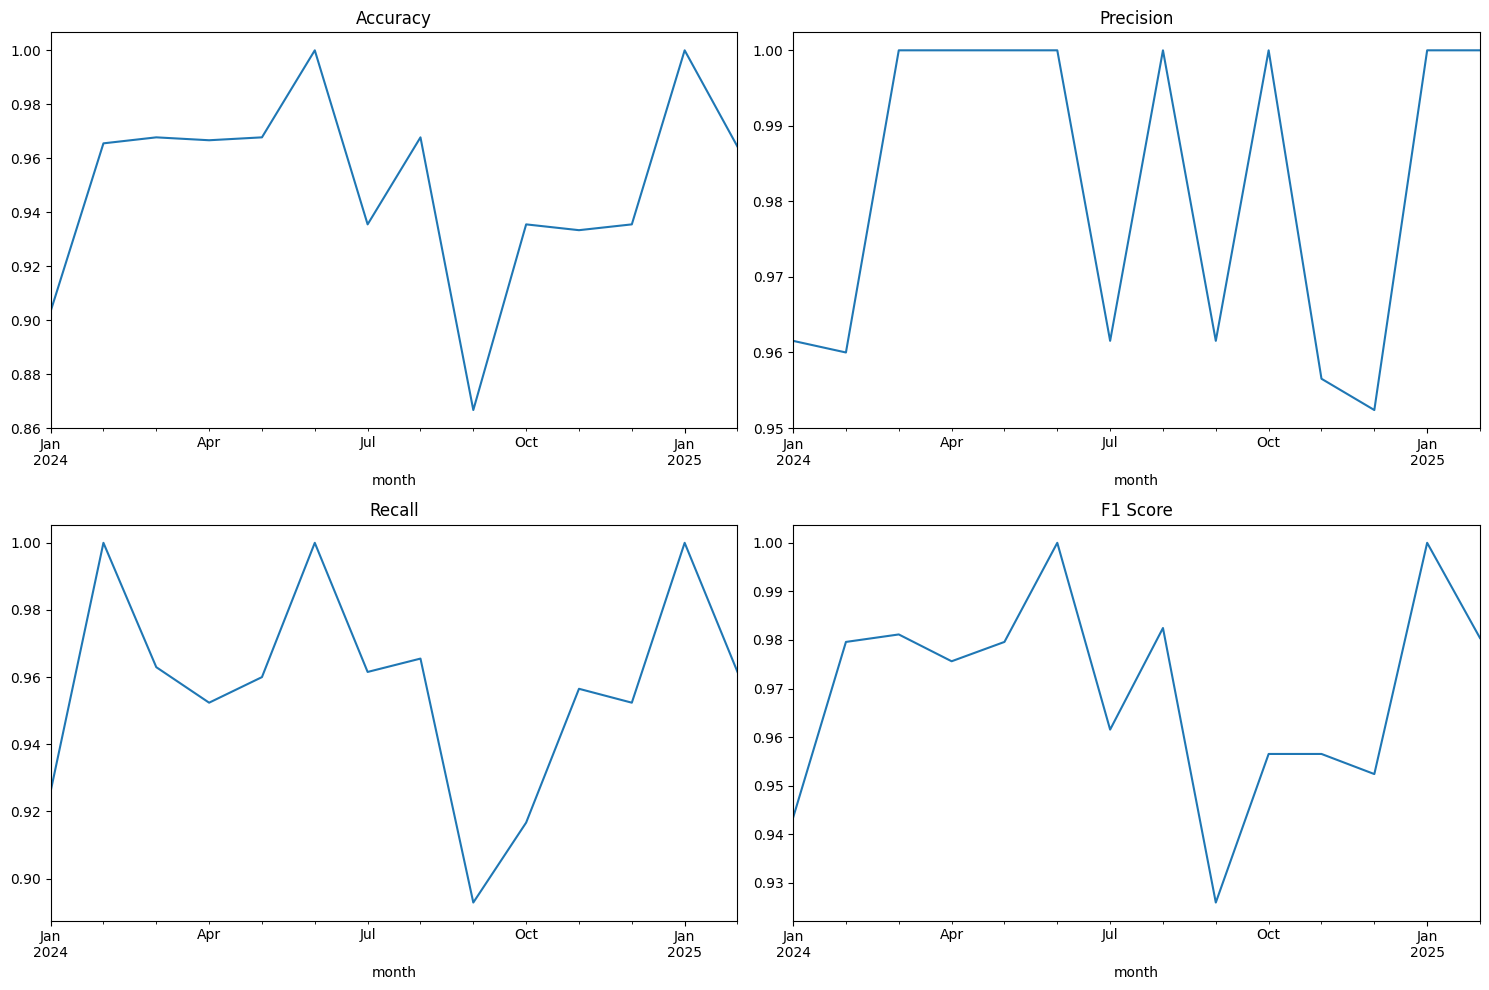

In [36]:
# Add a 'month' column to the dataframe
df_to_print = df.copy()

# Convert 'date' column to datetime
df_to_print['date'] = pd.to_datetime(df_to_print['date'])

df_to_print['month'] = df['date'].dt.to_period('M')

# Group by month and calculate performance metrics
monthly_metrics = df_to_print.groupby('month').apply(lambda x: pd.Series({
    'accuracy': accuracy_score(x['walk'].dropna(), predicted_walk.loc[x.index]['walk']),
    'precision': precision_score(x['walk'].dropna(), predicted_walk.loc[x.index]['walk']),
    'recall': recall_score(x['walk'].dropna(), predicted_walk.loc[x.index]['walk']),
    'f1_score': f1_score(x['walk'].dropna(), predicted_walk.loc[x.index]['walk'])
}))

# Plot the metrics
fig, ax = plt.subplots(2, 2, figsize=(15, 10))

monthly_metrics['accuracy'].plot(ax=ax[0, 0], title='Accuracy')
monthly_metrics['precision'].plot(ax=ax[0, 1], title='Precision')
monthly_metrics['recall'].plot(ax=ax[1, 0], title='Recall')
monthly_metrics['f1_score'].plot(ax=ax[1, 1], title='F1 Score')

plt.tight_layout()
plt.show()

## Correlation

`model` (Instance of pgmpy.base.DAG or pgmpy.models.BayesianNetwork) – The model which needs to be tested.

`data` (pandas.DataFrame instance) – The dataset against which to test the model structure.

`test` (str or function) – The statistical tests to use for determining whether the variables in data are correlated or not. For discrete variables, the options are: 1) chi_square 2) g_sq 3) log_likelihood 4) freeman_tuckey 5) modified_log_likelihood 6) neyman 7) cressie_read. For continuous variables only one test is available: 1) pearsonr. A function with the signature fun(X, Y, Z, data) can also be passed which returns True for uncorrelated and False otherwise.

`significance_level` (float) – A value between 0 and 1. If p_value < significance_level, the variables are considered uncorrelated.

`score` (function (default: f1-score)) – Any classification scoring metric from scikit-learn. https://scikit-learn.org/stable/modules/classes.html#classification-metrics

In [37]:
data_corr = model.simulate(int(1e4))

# Calculate the correlation score
correlation = correlation_score(model, data_corr, test='chi_square', significance_level=0.05, return_summary=True)

print(f"Correlation Score: {correlation}")

  0%|          | 0/6 [00:00<?, ?it/s]

Correlation Score:            var1      var2  stat_test  d_connected
0   temperature      mood      False        False
1   temperature      rain      False        False
2   temperature  sunlight      False        False
3   temperature      wind       True         True
4   temperature      walk      False        False
5          mood      rain      False        False
6          mood  sunlight      False        False
7          mood      wind      False        False
8          mood      walk      False        False
9          rain  sunlight      False        False
10         rain      wind      False        False
11         rain      walk      False        False
12     sunlight      wind      False        False
13     sunlight      walk      False        False
14         wind      walk      False        False


## Log likelyhood

The log-likelihood measure can be used to check how well the specified model describes the data. This method requires the parameters of the model to be specified as well. Direct interpretation of this score is difficult but can be used to compare the fit of two or more models. A higher score means a better fit.

In [38]:
log_likelyhood = log_likelihood_score(model, data_corr)
log_likelyhood

np.float64(-119556.97776011046)

## Get the Conditional Probability Distribution

In [39]:
cpds = model.get_cpds()
pprint.pp(cpds)

[<TabularCPD representing P(temperature:46) at 0x187465d2330>,
 <TabularCPD representing P(mood:117 | rain:2, sunlight:2, temperature:46, wind:41) at 0x187465d2180>,
 <TabularCPD representing P(rain:2 | temperature:46, wind:41) at 0x187465d0680>,
 <TabularCPD representing P(sunlight:2 | temperature:46, wind:41) at 0x187465d28d0>,
 <TabularCPD representing P(wind:41) at 0x187465d2450>,
 <TabularCPD representing P(walk:2 | mood:117) at 0x187465d23c0>]


In [40]:
for cpd in model.get_cpds():
    print(cpd)

+------------------+------------+
| temperature(-10) | 0.0141176  |
+------------------+------------+
| temperature(-9)  | 0.00705882 |
+------------------+------------+
| temperature(-8)  | 0.00705882 |
+------------------+------------+
| temperature(-7)  | 0.00941176 |
+------------------+------------+
| temperature(-6)  | 0.00470588 |
+------------------+------------+
| temperature(-5)  | 0.0235294  |
+------------------+------------+
| temperature(-4)  | 0.0188235  |
+------------------+------------+
| temperature(-3)  | 0.0329412  |
+------------------+------------+
| temperature(-2)  | 0.0376471  |
+------------------+------------+
| temperature(-1)  | 0.0282353  |
+------------------+------------+
| temperature(0)   | 0.0258824  |
+------------------+------------+
| temperature(1)   | 0.0305882  |
+------------------+------------+
| temperature(2)   | 0.0470588  |
+------------------+------------+
| temperature(3)   | 0.0376471  |
+------------------+------------+
| temperature(

use CPDs

In [41]:
# Create an inference object
inference = VariableElimination(model)

# Perform inference to find the probability of 'walk' given evidence
evidence = {'mood': -22, 'rain': 0, 'sunlight': 1, 'temperature': 9, 'wind': 11}
result = inference.query(variables=['walk'], evidence=evidence)

# Print the result
print(result)

+---------+-------------+
| walk    |   phi(walk) |
+=========+=============+
| walk(0) |      0.6667 |
+---------+-------------+
| walk(1) |      0.3333 |
+---------+-------------+


# Simulate & predict based on new data

## load the new data

In [42]:
# Load the new data
df_to_predict = pd.read_csv('./data/to_predict_long.csv')
df_to_predict['date'] = pd.to_datetime(df_to_predict['date'])
df_to_predict.head()

,date,temperature,month,seasons,rain,sunlight,wind,mood,walk
0,2024-01-01,-7,Jan,Winter,0,1,17,11,1
1,2024-01-02,-3,Jan,Winter,0,1,12,17,1
2,2024-01-03,-10,Jan,Winter,0,1,12,24,1
3,2024-01-04,-7,Jan,Winter,0,1,16,16,1
4,2024-01-05,-2,Jan,Winter,1,0,32,-48,0


## Use the loaded data to predict

In [43]:
# Make predictions
y_pred = model.predict(df_to_predict.drop(columns=['walk', 'date', 'month', 'seasons']))

# Calculate metrics
accuracy = accuracy_score(df_to_predict['walk'], y_pred['walk'])
recall = recall_score(df_to_predict['walk'], y_pred['walk'], average='binary')  # Change 'binary' to 'macro' or 'micro' if needed
precision = precision_score(df_to_predict['walk'], y_pred['walk'], average='binary')
f1 = f1_score(df_to_predict['walk'], y_pred['walk'], average='binary')

# Print metrics
print(f'Accuracy: {accuracy:.4f}')
print(f'Recall: {recall:.4f}')
print(f'Precision: {precision:.4f}')
print(f'F1 Score: {f1:.4f}')

  0%|          | 0/420 [00:00<?, ?it/s]

Accuracy: 0.9518
Recall: 0.9579
Precision: 0.9838
F1 Score: 0.9707


## GUI to predict `walk`

In [44]:
# Create sliders for the input variables
temperature_slider = widgets.IntSlider(min=-10, max=40, step=1, description='Temperature')
rain_slider = widgets.IntSlider(min=0, max=1, step=1, description='Rain')
sunlight_slider = widgets.IntSlider(min=0, max=1, step=1, description='Sunlight')
wind_slider = widgets.IntSlider(min=0, max=50, step=1, description='Wind')
mood_slider = widgets.IntSlider(min=-50, max=50, step=1, description='Mood')

# Create a button for prediction
predict_button = widgets.Button(description='Predict if I walk')

# Create an output widget to display the result
output = widgets.Output()

# Define the function to be called when the button is clicked
def predict_walk(b):
    # Get the values from the sliders
    temperature = temperature_slider.value
    rain = rain_slider.value
    sunlight = sunlight_slider.value
    wind = wind_slider.value
    
    # Create a new instance of data
    new_data = pd.DataFrame([{
        'temperature': temperature,
        'rain': rain,
        'sunlight': sunlight,
        'wind': wind
    }])
    
    # Perform inference to predict 'walk'
    prediction = model.predict(new_data)
    
    # Display the result
    with output:
        output.clear_output()
        print(f"Predicted walk: {prediction['walk'].values[0]}")

# Attach the function to the button
predict_button.on_click(predict_walk)

# Display the widgets
display(temperature_slider, rain_slider, sunlight_slider, wind_slider, predict_button, output)

IntSlider(value=0, description='Temperature', max=40, min=-10)

IntSlider(value=0, description='Rain', max=1)

IntSlider(value=0, description='Sunlight', max=1)

IntSlider(value=0, description='Wind', max=50)

Button(description='Predict if I walk', style=ButtonStyle())

Output()

## GUI to do inference to understand context

In [45]:
# Print the state names for the 'mood' variable
print(model.get_cpds('mood').state_names['mood'])

# Print the state names for other variables if needed
print(model.get_cpds('temperature').state_names['temperature'])
print(model.get_cpds('rain').state_names['rain'])
print(model.get_cpds('sunlight').state_names['sunlight'])
print(model.get_cpds('wind').state_names['wind'])

[-58, -57, -56, -55, -54, -53, -52, -51, -50, -49, -48, -47, -46, -45, -44, -43, -42, -41, -40, -39, -38, -37, -36, -35, -34, -33, -32, -31, -30, -29, -28, -27, -26, -25, -24, -23, -22, -21, -20, -19, -18, -17, -16, -15, -14, -13, -12, -11, -10, -9, -8, -7, -6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58]
[-10, -9, -8, -7, -6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35]
[0, 1]
[0, 1]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40]


In [46]:
# Create sliders for the input variables
temperature_slider = widgets.IntSlider(min=-10, max=30, step=1, description='Temperature')
rain_slider = widgets.IntSlider(min=0, max=1, step=1, description='Rain')
sunlight_slider = widgets.IntSlider(min=0, max=1, step=1, description='Sunlight')
wind_slider = widgets.IntSlider(min=0, max=50, step=1, description='Wind')
mood_slider = widgets.IntSlider(min=-50, max=50, step=1, description='Mood')

# Create a button for prediction
predict_button = widgets.Button(description='Probability of walking')

# Create an output widget to display the result
output = widgets.Output()

# Define the function to be called when the button is clicked
def predict_walk(b):
    print("Debug Current system time:", datetime.now())
    # Get the values from the sliders
    temperature = temperature_slider.value
    rain = rain_slider.value
    sunlight = sunlight_slider.value
    wind = wind_slider.value
    mood = mood_slider.value
    
    # Create evidence dictionary
    evidence = {
        'temperature': temperature,
        'rain': rain,
        'sunlight': sunlight,
        'wind': wind,
        'mood': mood
    }
    
    # Perform inference to predict 'walk'
    result = inference.query(variables=['walk'], evidence=evidence)
    
    # # Display the result
    with output:
        output.clear_output()
        print(f"Predicted walk probability: {result}")
        print(f"Temperature: {temperature}, Rain: {rain}, Sunlight: {sunlight}, Wind: {wind}, Mood: {mood}")

# Attach the function to the button
predict_button.on_click(predict_walk)

# Display the widgets
display(temperature_slider, rain_slider, sunlight_slider, wind_slider, mood_slider, predict_button, output)

IntSlider(value=0, description='Temperature', max=30, min=-10)

IntSlider(value=0, description='Rain', max=1)

IntSlider(value=0, description='Sunlight', max=1)

IntSlider(value=0, description='Wind', max=50)

IntSlider(value=0, description='Mood', max=50, min=-50)

Button(description='Probability of walking', style=ButtonStyle())

Output()

## Visulalize probablilities of `walk` based on input variables

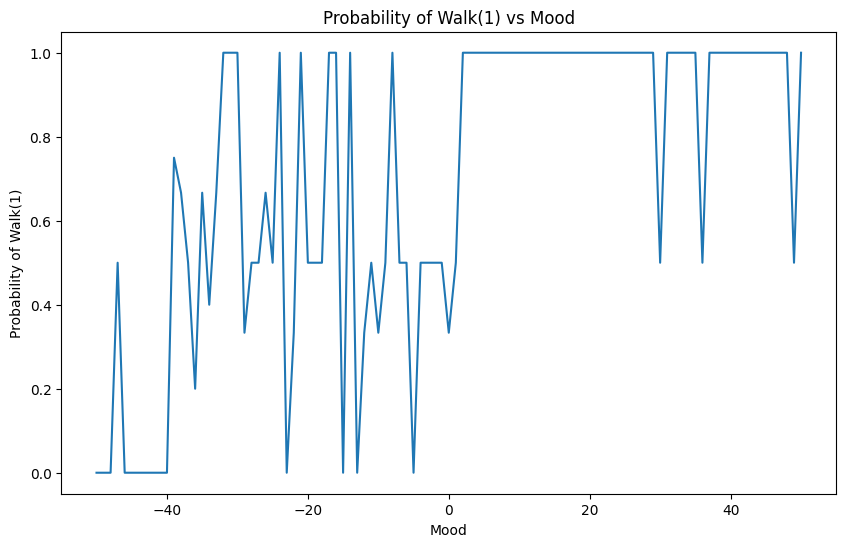

In [47]:
import seaborn as sns

# Create a list to store the probabilities
probabilities = []

# Vary the mood from -50 to 50
for mood in range(-50, 51):
    # Create evidence dictionary
    evidence = {
        'temperature': temperature_slider.value,
        'rain': rain_slider.value,
        'sunlight': sunlight_slider.value,
        'wind': wind_slider.value,
        'mood': mood
    }
    
    # Perform inference to predict 'walk'
    result = inference.query(variables=['walk'], evidence=evidence)
    
    # Extract the probability of walk(1)
    prob_walk_1 = result.values[1]
    
    # Append the probability to the list
    probabilities.append(prob_walk_1)

# Create a DataFrame for visualization
df_probabilities = pd.DataFrame({'Mood': range(-50, 51), 'Probability of Walk(1)': probabilities})

# Plot the probabilities using seaborn
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_probabilities, x='Mood', y='Probability of Walk(1)')
plt.title('Probability of Walk(1) vs Mood')
plt.xlabel('Mood')
plt.ylabel('Probability of Walk(1)')
plt.show()

In [50]:
import ipywidgets as widgets
from IPython.display import display
from pgmpy.inference import VariableElimination

# Create sliders for the input variables
temperature_slider = widgets.IntSlider(min=-10, max=30, step=1, description='Temperature')
rain_slider = widgets.IntSlider(min=0, max=1, step=1, description='Rain')
sunlight_slider = widgets.IntSlider(min=0, max=1, step=1, description='Sunlight')
wind_slider = widgets.IntSlider(min=0, max=50, step=1, description='Wind')

# Create a button for prediction
predict_button = widgets.Button(description='Probability of walking')

# Create an output widget to display the result
output = widgets.Output()

# Create an inference object
inference = VariableElimination(model)

# Define the function to be called when the button is clicked
def predict_walk(b):
    # Get the values from the sliders
    temperature = temperature_slider.value
    rain = rain_slider.value
    sunlight = sunlight_slider.value
    wind = wind_slider.value
    
    # Create evidence dictionary
    evidence = {
        'temperature': temperature,
        'rain': rain,
        'sunlight': sunlight,
        'wind': wind
    }
    
    # Perform inference to predict 'mood'
    mood_result = inference.query(variables=['mood'], evidence=evidence)
    mood = mood_result.values.argmax()  # Get the most probable mood state
    
    # Update evidence with the predicted mood
    evidence['mood'] = mood
    
    # Perform inference to predict 'walk'
    walk_result = inference.query(variables=['walk'], evidence=evidence)
    
    # Display the result
    with output:
        output.clear_output()
        # print(f"Predicted walk probability: {mood_result}")
        print(f"Predicted walk probability: {walk_result}")
        print(f"Temperature: {temperature}, Rain: {rain}, Sunlight: {sunlight}, Wind: {wind}, Mood: {mood}")

# Attach the function to the button
predict_button.on_click(predict_walk)

# Display the widgets
display(temperature_slider, rain_slider, sunlight_slider, wind_slider, predict_button, output)

IntSlider(value=0, description='Temperature', max=30, min=-10)

IntSlider(value=0, description='Rain', max=1)

IntSlider(value=0, description='Sunlight', max=1)

IntSlider(value=0, description='Wind', max=50)

Button(description='Probability of walking', style=ButtonStyle())

Output()

c:\Users\adhav\AppData\Local\Programs\Python\Python313\Lib\site-packages\pgmpy\inference\ExactInference.py:763: SyntaxWarning: invalid escape sequence '\s'
  """


KeyError: 50

<Figure size 1000x600 with 0 Axes>

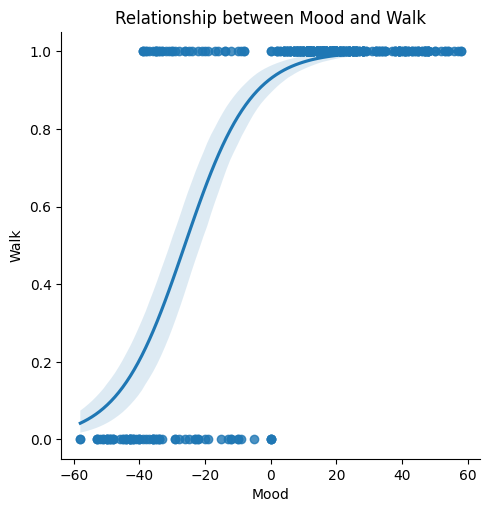

In [49]:
import seaborn as sns

# Plot the relationship between mood and walk using a linear model
plt.figure(figsize=(10, 6))
sns.lmplot(x='mood', y='walk', data=df, logistic=True)
plt.title('Relationship between Mood and Walk')
plt.xlabel('Mood')
plt.ylabel('Walk')
plt.show()

## Sensitivity analysis